In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
import sys
sys.path.append('./src') 
from preprocessor import load_and_preprocess, reverse_preprocessing
from tqdm import tqdm
import torch
import qwen
from torch.utils.data import DataLoader, TensorDataset
import os

In [2]:
with h5py.File("lotka_volterra_data.h5", "r") as f:
    # Access the full dataset
    trajectories = f["trajectories"][:] # Shape: (n_systems, n_time_points, n_species)
    time_points = f["time"][:]
    # Access a single trajectory
    system_id = 0 # First system
    # All 100 time points:
    prey_0 = trajectories[0, :, 0]
    predator_0 = trajectories[0, :, 1]
    times = time_points[:]

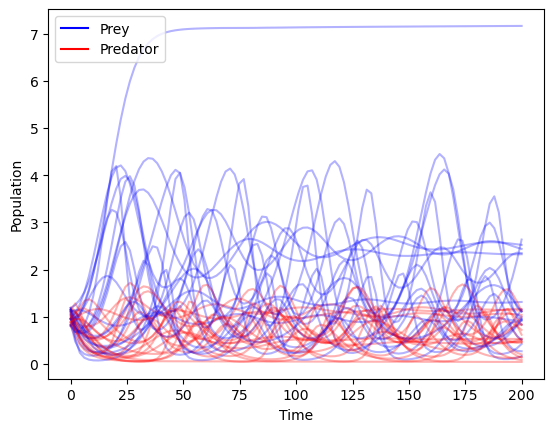

In [3]:
for sys in range(20):
    prey = trajectories[sys, :, 0]
    predator = trajectories[sys, :, 1]
    plt.plot(times, prey, alpha=0.3, c='b')
    plt.plot(times, predator , alpha=0.3, c='r')

plt.xlabel("Time")
plt.ylabel("Population")

plt.plot([], [], label="Prey", c='b')  # Dummy plot for "Prey"
plt.plot([], [], label="Predator", c='r')  # Dummy plot for "Predator"

plt.legend()

# Preprocessing

In [4]:
torch.mps.empty_cache() 
model, tokenizer = qwen.load_qwen()
torch.mps.empty_cache() 
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Using device: mps


Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbe

In [5]:
train_data , val_data ,test_data, norm_factor= load_and_preprocess('lotka_volterra_data.h5')
print(np.shape(train_data))  # First 800 systems
print(np.shape(val_data)) 
print(np.shape(test_data)) 
print('Normalisation factor', norm_factor)

(800,)
(100,)
(100,)
Normalisation factor 3.4500234


In [6]:

tokenised_train = [
    tokenizer(train_data[sys], return_tensors="pt")["input_ids"].tolist()[0] for sys in range(np.shape(train_data)[0]) ]

tokenised_val = [
    tokenizer(val_data[sys], return_tensors="pt")["input_ids"].tolist()[0] for sys in range(np.shape(val_data)[0]) ]

tokenised_test = [
    tokenizer(test_data[sys], return_tensors="pt")["input_ids"].tolist()[0] for sys in range(np.shape(test_data)[0]) ]

In [7]:
for sys_id in range(2):  # Loop through the first two systems (0 and 1)
    print(f"--- System {sys_id} ---")
    print(f"Preprocessed: {train_data[sys_id]}")
    print(f"Tokenised: {tokenised_train[sys_id]}")
    print('----------------------------------')


--- System 0 ---
Preprocessed: 0.275,0.302;0.215,0.226;0.198,0.164;0.208,0.118;0.239,0.087;0.291,0.067;0.366,0.054;0.465,0.047;0.589,0.045;0.731,0.047;0.881,0.054;1.020,0.069;1.120,0.093;1.153,0.131;1.094,0.183;0.944,0.240;0.739,0.284;0.546,0.294;0.408,0.269;0.331,0.225;0.299,0.179;0.298,0.141;0.321,0.113;0.366,0.092;0.430,0.079;0.513,0.072;0.611,0.071;0.718,0.074;0.822,0.084;0.905,0.101;0.951,0.126;0.943,0.159;0.875,0.196;0.761,0.228;0.630,0.246;0.514,0.242;0.432,0.220;0.386,0.191;0.370,0.161;0.378,0.135;0.406,0.116;0.452,0.102;0.513,0.094;0.585,0.091;0.663,0.093;0.738,0.100;0.798,0.113;0.833,0.131;0.833,0.155;0.794,0.180;0.723,0.202;0.637,0.215;0.555,0.215;0.489,0.204;0.447,0.185;0.428,0.164;0.429,0.144;0.448,0.128;0.483,0.116;0.529,0.109;0.583,0.106;0.641,0.107;0.695,0.113;0.738,0.124;0.761,0.138;0.761,0.155;0.734,0.172;0.686,0.187;0.628,0.196;0.569,0.197;0.520,0.190;0.486,0.177;0.469,0.162;0.469,0.148;0.483,0.135;0.509,0.125;0.545,0.119;0.587,0.117;0.630,0.118;0.670,0.123;0.700,0.1

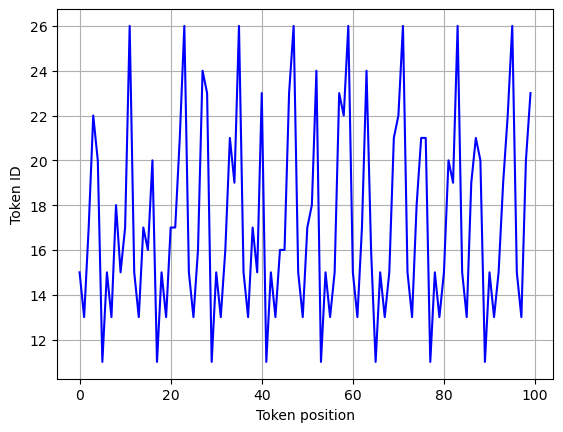

In [8]:
plt.plot(tokenised_train[0][:100], label="Prey", c='b')
plt.xlabel("Token position")
plt.ylabel("Token ID")
plt.grid()

# Untrained model

In [9]:
tokenised_tensors_train = torch.stack([torch.tensor(seq, dtype=torch.long).to(device) for seq in tokenised_train])
tokenised_tensors_val = torch.stack([torch.tensor(seq, dtype=torch.long).to(device) for seq in tokenised_val])
tokenised_tensors_test = torch.stack([torch.tensor(seq, dtype=torch.long).to(device) for seq in tokenised_test])
print(tokenised_tensors_train.shape)
print(tokenised_tensors_val.shape)
print(tokenised_tensors_test.shape)


torch.Size([800, 1199])
torch.Size([100, 1199])
torch.Size([100, 1199])


In [10]:
decimal_places = 3
tokens_per_time_point = (6+2*decimal_places)
training_token_id = 80*tokens_per_time_point # 80 time points, 12 tokens per time point

In [11]:
# Set the maximum number of tokens to generate
max_new_tokens = 20*tokens_per_time_point-1 #239

# Initialize a list to store predicted tokens
predicted_tokens_list = []
num_sys = 6

model.eval()
# Create a progress bar
with torch.no_grad():
    for sys in tqdm(range(num_sys), desc="Generating Tokens"):
        # Slice the data for the current batch and set the `training_token_id`
        data = tokenised_tensors_test[sys][ :training_token_id]
        data = data.unsqueeze(0)
        predicted_trajectories = []
        for _ in range(3):  # Loop for 3 trajectories
            predicted_tokens_batch = model.generate(data, max_new_tokens=max_new_tokens)
            predicted_tokens_batch = predicted_tokens_batch.squeeze(0)
            predicted_trajectories.append(predicted_tokens_batch)

        # Store the 3 predicted trajectories for this system in the list
        predicted_tokens_list.append(predicted_trajectories)
        
        torch.mps.empty_cache() 

# After looping through the batches, convert the list of predicted tokens to a tensor
# all_predicted_tokens = torch.cat(predicted_tokens_list, dim=0)
all_predicted_tokens = torch.stack([torch.stack(trajectories) for trajectories in predicted_tokens_list])


Generating Tokens:   0%|          | 0/6 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Generating Tokens: 100%|██████████| 6/6 [04:21<00:00, 43.57s/it]


In [20]:
print(all_predicted_tokens.shape)  

torch.Size([6, 3, 1199])
torch.Size([100, 1199])


In [21]:
print('Traget tokens:', tokenised_tensors_test[0, training_token_id:training_token_id + 40])
print('Predicted tokens:', all_predicted_tokens[0,0, training_token_id:training_token_id + 40])

Traget tokens: tensor([15, 13, 17, 18, 15, 11, 15, 13, 16, 16, 19, 26, 15, 13, 17, 20, 21, 11,
        15, 13, 16, 18, 24, 26, 15, 13, 17, 21, 18, 11, 15, 13, 16, 22, 18, 26,
        15, 13, 17, 19], device='mps:0')
Predicted tokens: tensor([15, 13, 17, 18, 20, 11, 15, 13, 16, 16, 20, 26, 15, 13, 17, 22, 15, 11,
        15, 13, 16, 18, 23, 26, 15, 13, 17, 24, 20, 11, 15, 13, 16, 22, 18, 26,
        15, 13, 18, 16], device='mps:0')


In [22]:
decoded_predictions = []

for sys in range(len(all_predicted_tokens)):
    predicted_tokens = all_predicted_tokens[sys]
    # predicted_tokens = torch.cat(predicted_tokens, dim=0)  # This flattens the tokens
    decoded_sys_predictions = [
        tokenizer.decode(tokens, skip_special_tokens=True) for tokens in predicted_tokens
    ]
    decoded_predictions.append(decoded_sys_predictions)

print('Predictions:', decoded_predictions[0][0][training_token_id:training_token_id + 60])
print('Target:', val_data[0][training_token_id:training_token_id + 60])

Predictions: 0.235,0.115;0.270,0.138;0.295,0.173;0.317,0.209;0.324,0.264;
Target: 0.944,0.054;0.972,0.089;0.912,0.147;0.745,0.223;0.516,0.286;


In [15]:
# def reverse_preprocessing(data):
#     # Split the string by semicolons to get pairs
#     pairs = data.split(';')
    
#     # Remove any empty string after the final semicolon
#     pairs = [pair for pair in pairs if pair]
    
#     # Initialize two empty arrays for A and B
#     A = []
#     B = []
    
#     # Iterate over each pair, split it by comma, and append to respective arrays
#     for pair in pairs:
#         a, b = pair.split(',')
#         A.append(float(a))  # Convert the first part to float and append to A
#         B.append(float(b))  # Convert the second part to float and append to B
    
#     return A, B

In [28]:
predicted_prey = []
predicted_predator = []

for sys in range(len(decoded_predictions)):
    preys = []
    predators = []
    for traj in range(len(decoded_predictions[sys])):
        prey, pred = reverse_preprocessing(decoded_predictions[sys][traj])
        preys.append(prey)
        predators.append(pred)
    predicted_prey.append(preys)
    predicted_predator.append(predators)

if not os.path.exists('results'):
    os.makedirs('results')
    print(f"Created folder: results")
np.save('results/qwen_predicted_prey.npy', predicted_prey)
np.save('results/qwen_predicted_predator.npy', predicted_predator)

# Count NaN values in predicted_prey
nan_prey = np.sum(np.isnan(predicted_prey))

# Count NaN values in predicted_predator
nan_predator = np.sum(np.isnan(predicted_predator))

print(f"Number of NaN values in predicted_prey: {nan_prey}")
print(f"Number of NaN values in predicted_predator: {nan_predator}")




Number of NaN values in predicted_prey: 0
Number of NaN values in predicted_predator: 0


In [24]:
def mse(pred, true):
    return np.mean((np.array(pred) - np.array(true))**2)


System 1: Prey MSE = 0.003, Predator MSE = 0.002
System 2: Prey MSE = 0.005, Predator MSE = 0.025
System 3: Prey MSE = 0.114, Predator MSE = 0.006
System 4: Prey MSE = 0.179, Predator MSE = 0.036
System 5: Prey MSE = 0.006, Predator MSE = 0.003
System 6: Prey MSE = 0.014, Predator MSE = 0.007


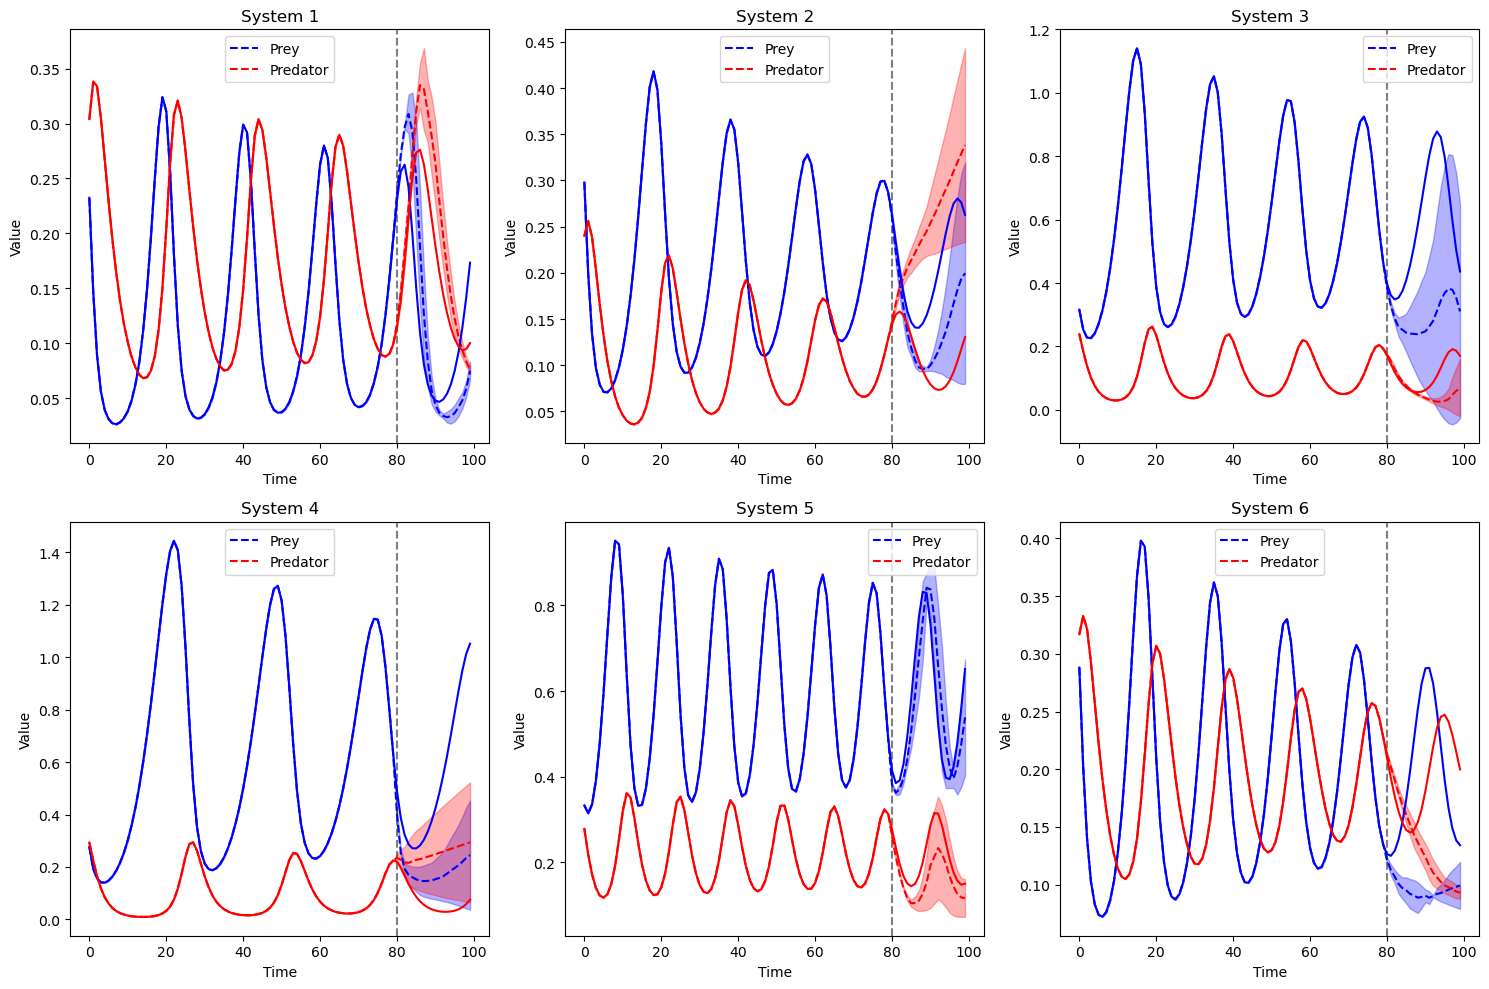

In [29]:

# Number of systems you want to plot (e.g., 6 systems)
num_systems = 6
num_rows = 2
num_columns = 3

# Create a figure with a grid of num_rows and num_columns
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 10))

# Flatten axes array if it's 2D
axes = axes.flatten()

# Loop through each system and plot on the corresponding subplot
for sys in range(num_systems):
    orig_sys= sys+900
    prey_mean = np.mean(predicted_prey[sys], axis=0)
    predator_mean = np.mean(predicted_predator[sys], axis=0)
    prey_std = np.std(predicted_prey[sys], axis=0)
    predator_std = np.std(predicted_predator[sys], axis=0)

    axes[sys].axvline(80, c='k', linestyle='--', alpha=0.5)

    axes[sys].plot(prey_mean, label="Prey", c='b', linestyle='--')
    axes[sys].fill_between(range(len(prey_mean)), prey_mean - prey_std, prey_mean + prey_std, color='b', alpha=0.3)

    axes[sys].plot(predator_mean, label="Predator", c='r', linestyle='--')
    axes[sys].fill_between(range(len(predator_mean)), predator_mean - predator_std, predator_mean + predator_std, color='r', alpha=0.3)


    # axes[sys].plot(predicted_prey[sys][traj], label="Prey", c='b',linestyle='--')
    # axes[sys].plot(predicted_predator[sys][traj], label="Predator", c='r',linestyle='--')
    axes[sys].plot(trajectories[orig_sys][:,0]/norm_factor, c='b') 
    axes[sys].plot(trajectories[orig_sys][:,1]/norm_factor, c='r')

    # Add labels and title for each subplot
    axes[sys].set_title(f'System {sys+1}')
    axes[sys].set_xlabel('Time')
    axes[sys].set_ylabel('Value')

    # Add a legend
    axes[sys].legend()
    mse_prey = mse(prey_mean[80:], trajectories[orig_sys][80:,0]/norm_factor)
    mse_predator = mse(predator_mean[80:], trajectories[orig_sys][80:,1]/norm_factor)
    print(f"System {sys+1}: Prey MSE = {mse_prey:.3f}, Predator MSE = {mse_predator:.3f}") 
        

plt.tight_layout()

# Show the plot

plt.savefig('plots/system_forecasts.png')


In [19]:
# Compute accuracy (example metric)
print(n_future_tokens)
print(all_predicted_tokens.shape)
print(target_tokens.shape)
accuracy = (all_predicted_tokens == target_tokens).float().mean().item()
print(f"Model Accuracy: {accuracy:.4f}")

NameError: name 'n_future_tokens' is not defined

In [13]:
target_texts = [tokenizer.decode(token_ids, skip_special_tokens=False) for token_ids in np.array(target_tokens)]
predicted_texts = [tokenizer.decode(token_ids, skip_special_tokens=False) for token_ids in np.array(all_predicted_tokens)]

print('Target points: ',target_texts[0], 'Predicted point: ',predicted_texts[0])
print('Target points: ',target_texts[1], 'Predicted point: ',predicted_texts[1])
print('Target points: ',target_texts[2], 'Predicted point: ',predicted_texts[2])

# The predicted tokens aren't in the same format as the target tokens - run this on 10 and get MSE after removing weird bits

Target points:  0.700,0.131;0.716,0.142;0.713,0.155;0.693,0.168;0.659,0.178;0.617,0.184;0.574,0.184;0.538,0.179;0.513,0.170;0.500,0.160;0.499,0.149;0.510,0.139;0.531,0.132;0.559,0.127;0.591,0.125;0.623,0.126;0.652,0.130;0.673,0.137;0.683,0.146;0.680,0.155 Predicted point:  0055 \ .225, .275,0.385;0.198,0.298;0.105,0.188;0.115,0.085;0.258,0.065;0.305,0.051;0.408,0.042;0.565,0.041;0.705,0.043;0.855,0.044;0.005,0.067;1.180,0.070;1.290,0.110;1.120,0.160;0.958,0.245;0.891,0.399;0.518,0.399;0.308,0.398;0.203,0.245;
Target points:  0.679,0.339;0.673,0.334;0.672,0.327;0.675,0.321;0.681,0.316;0.691,0.312;0.702,0.309;0.715,0.308;0.727,0.308;0.737,0.310;0.746,0.313;0.752,0.316;0.755,0.321;0.754,0.325;0.750,0.330;0.743,0.333;0.734,0.336;0.724,0.338;0.715,0.338;0.706,0.337 Predicted point:  00558 .285, .202,0.394;0.325,0.295;0.407,0.148;0.503,0.141;0.625,0.130;0.771,0.141;0.903,0.145;1.001,0.162;1.184,0.199;1.250,0.210;1.289,0.265;1.298,0.311;1.146,0.365;1.980,0.421;0.884,0.471;0.734,0.499;0.612,0.

In [54]:
def reverse_processing(processed_trajectories):
    trajectories = []
    for sys in processed_trajectories:
        trajectory = []
        time_steps = sys.split(';')
        # print(time_steps)
        for step in time_steps:
            try:
                prey_val, predator_val = step.split(',')
                prey_val = float(prey_val)
                predator_val = float(predator_val)
            except ValueError:
                prey_val = np.nan
                predator_val = np.nan
            if len(trajectory) < n_future_points - 1:
                trajectory.append([prey_val, predator_val])
        trajectories.append(np.array(trajectory))
    return np.array(trajectories)

In [60]:
final_predicted_trajectories = reverse_processing(predicted_texts)
final_target_trajectories = reverse_processing(target_texts)
squared_error = (final_predicted_trajectories - final_target_trajectories) ** 2
mask = np.isnan(final_predicted_trajectories)

# Set squared error to NaN wherever final_predicted_trajectories is NaN
squared_error[mask] = np.nan

# Compute the Mean Squared Error while ignoring NaNs
mse = np.nanmean(squared_error)

print(f"Mean Squared Error (ignoring NaNs in predicted trajectories): {mse:.4f}")

Mean Squared Error (ignoring NaNs in predicted trajectories): 0.1164


In [ ]:
generated_predictions = model

In [14]:
# # Perform inference without gradients (faster)
# with torch.no_grad():
#     outputs = model(tokenized_tensors)

# # Extract the next token predictions (logits)
# logits = outputs.logits  # Shape: (batch_size, seq_length, vocab_size)
# predicted_tokens = torch.argmax(logits, dim=-1)  # Get most likely token IDs

# from tqdm import tqdm
# import torch

# # Perform inference with progress bar
# with torch.no_grad():
#     # Initialize the tqdm progress bar
#     for batch in tqdm(tokenized_tensors, desc="Processing", unit="batch"):
#         # Perform inference for each batch
#         outputs = model(batch)
        
#         # Extract the next token predictions (logits)
#         logits = outputs.logits  # Shape: (batch_size, seq_length, vocab_size)
#         predicted_tokens = torch.argmax(logits, dim=-1)  # Get most likely token IDs
